# QTM 151 Final Project
## Project Members: Tammy Dang, Bao Truong, Jocelyn Nguyen, Chau Anh Nguyen

### Data Description

The question we are examining with our dataset is:


*   **How does the frequency of pit stops correlate with the success rate of driver victories in Formula 1 racing?**

In order to examine this, we will be parsing and analyzing these datasets:

1.   pit_stops.csv
2.   driver_standings.csv

Each row represents a driver within an F1 race. This will be distinct based on raceID and driverId.

# Import libraries 

In [12]:
# "pandas" processes datasets
# "maplotlib.pyplot" generates graphs
# datetime packages for time series manipulation

import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import date, time, datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re

# Import dataset
For our analysis we will be utilizing three datasets for F1 racing:


1.   pit_stops.csv
2.   driver_standings.csv


In [13]:
# Read the CSV file
driver_standings = pd.read_csv("data_raw/driver_standings.csv")
pit_stops = pd.read_csv("data_raw/pit_stops.csv")


In [14]:
# to see the data
display(driver_standings)
display(pit_stops)

# note: We will group them by raceId and driverId when merging

,driverStandingsId,raceId,driverId,points,position,positionText,wins
0,1,18,1,10.0,1,1,1
1,2,18,2,8.0,2,2,0
2,3,18,3,6.0,3,3,0
3,4,18,4,5.0,4,4,0
4,5,18,5,4.0,5,5,0
...,...,...,...,...,...,...,...
33897,71841,1098,840,0.0,16,16,0
33898,71842,1098,852,0.0,17,17,0
33899,71843,1098,830,0.0,18,18,0
33900,71844,1098,856,0.0,19,19,0


,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842
...,...,...,...,...,...,...,...
9629,1096,849,2,38,18:02:50,25.174,25174
9630,1096,840,2,40,18:04:44,21.802,21802
9631,1096,839,2,41,18:06:09,21.734,21734
9632,1096,846,2,42,18:07:36,21.559,21559


# MERGE
The following will be the merging process between driver_standings and pit_stops. They will be merged by grouping by raceId and driverId and inner joining the dataset. We will then use this to clean and create data descriptions to find out the dataset we can use for graphing, etc.

In [15]:
#merge driver_standings and pit_stops by raceId and driverId. Store this in data frame, merged_f1
merged_f1 = pd.merge(driver_standings, pit_stops, on =['raceId', 'driverId'], how ='inner')
display(merged_f1)

,driverStandingsId,raceId,driverId,points,position,positionText,wins,stop,lap,time,duration,milliseconds
0,68160,969,830,10.0,5,5,0,1,25,16:43:56,22.208,22208
1,68159,969,8,12.0,4,4,0,1,26,16:45:16,22.033,22033
2,68158,969,822,15.0,3,3,0,1,25,16:43:42,21.440,21440
3,68157,969,1,18.0,2,2,0,1,17,16:31:40,21.709,21709
4,68156,969,20,25.0,1,1,1,1,23,16:40:32,21.988,21988
...,...,...,...,...,...,...,...,...,...,...,...,...
9626,71821,1096,815,305.0,3,3,2,1,15,17:26:00,21.360,21360
9627,71821,1096,815,305.0,3,3,2,2,33,17:53:33,21.367,21367
9628,71822,1096,830,454.0,1,1,15,1,20,17:33:31,22.735,22735
9629,71823,1096,842,23.0,14,14,0,1,14,17:25:03,21.855,21855


# Data Description Diagnostic Commands
The following is code to understand the data we have better.

In [16]:
#How many observations do we have in the dataset?
n_total = len(merged_f1)

#count non-missing observations
n_nonmiss_wins = merged_f1["wins"].count()  # there are no NAs.
n_nonmiss_stop = merged_f1["stop"].count()  # there are no NAs.
n_nonmiss_points = merged_f1["points"].count() # there are no NAs.

# get unique values of race and driverId
list_ids_race = pd.unique(merged_f1["raceId"])
list_ids_driver = pd.unique(merged_f1["driverId"])

# NOTE: please group by race and driverId. As there are different races within this dataset with a participation of d

# Data Cleaning

In [17]:
# Use regular expression to clean "duration"
time_format = re.compile(r'^([0-5]?\d):([0-5]?\d)\.(\d{1,3})$') # regex of values like "16:44.718"
dropping_list = [] # create array of rows with the said regex

for index, row in merged_f1.iterrows(): #create for loop to iterate through merged_f1's rows
    if time_format.match(row['duration']):
        dropping_list.append(index)

merged_f1.drop(dropping_list, inplace=True)

# I realized that I don't actually need to do this because miliseconds is the cleaned version of duration
# But i'll keep it here so let me have my glory T.T. This took me 2 hours to figure out


In [18]:
# Aggregate by raceId and driverId, looking at total stops, pit time, and wins of each driverId
agg_table = merged_f1.groupby(["raceId", "driverId"]).agg(total_stops = ("stop", "sum"),
                                               total_pit_time = ("milliseconds", "sum"),
                                               total_wins = ("wins", "sum"),
                                               total_points = ("points", "sum"),
                                               total_lap = ("lap", "sum")).reset_index()
agg_table

,raceId,driverId,total_stops,total_pit_time,total_wins,total_points,total_lap
0,841,1,3,46426,0,36.0,52
1,841,2,3,48092,0,0.0,45
2,841,3,1,23716,0,0.0,16
3,841,4,6,72165,0,36.0,81
4,841,5,1,24865,0,0.0,17
...,...,...,...,...,...,...,...
4674,1096,848,3,43591,0,8.0,47
4675,1096,849,3,47597,0,4.0,53
4676,1096,852,3,43853,0,24.0,52
4677,1096,854,3,45806,0,24.0,48


Text(0, 0.5, 'Total Wins')

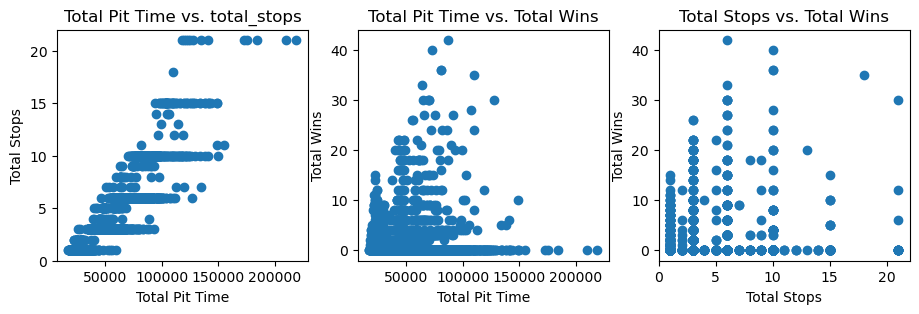

In [19]:
# Create subplots to assess the relationship between, Total Pit Time, Total Stops, Total Wins
fig, list_subfig = plt.subplots(1, 3, figsize = (11,3))

list_subfig[0].scatter(agg_table["total_pit_time"], agg_table["total_stops"])
list_subfig[0].set_title("Total Pit Time vs. total_stops")
list_subfig[0].set_xlabel("Total Pit Time")
list_subfig[0].set_ylabel("Total Stops")

list_subfig[1].scatter(agg_table["total_pit_time"], agg_table["total_wins"])
list_subfig[1].set_title("Total Pit Time vs. Total Wins")
list_subfig[1].set_xlabel("Total Pit Time")
list_subfig[1].set_ylabel("Total Wins")

list_subfig[2].scatter(agg_table["total_stops"], agg_table["total_wins"])
list_subfig[2].set_title("Total Stops vs. Total Wins")
list_subfig[2].set_xlabel("Total Stops")
list_subfig[2].set_ylabel("Total Wins")

Intercept         0.416698
total_pit_time    0.000012
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             total_wins   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     31.83
Date:                Wed, 24 Apr 2024   Prob (F-statistic):           1.78e-08
Time:                        16:35:06   Log-Likelihood:                -12236.
No. Observations:                4679   AIC:                         2.448e+04
Df Residuals:                    4677   BIC:                         2.449e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

Text(0, 0.5, 'Total Wins')

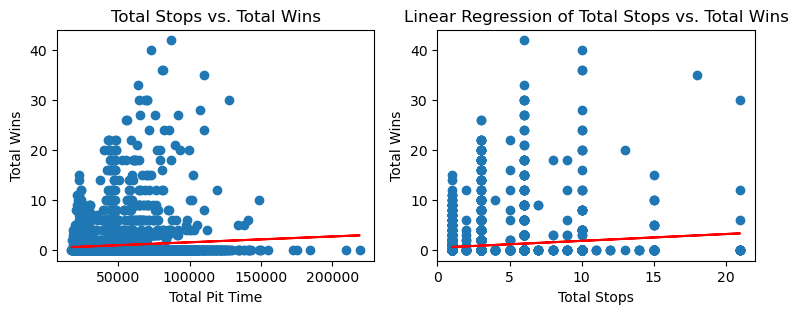

In [20]:
# Linear Regression 1: Total Pit Time and Total Wins with summary
results_pit_time = smf.ols("total_wins ~ total_pit_time", data=agg_table).fit()
print(results_pit_time.params)
print(results_pit_time.summary())

# Linear Regression 2: Total Stops and Total Wins with summary
results_stops = smf.ols("total_wins ~ total_stops", data=agg_table).fit()
print(results_stops.params)
print(results_stops.summary())


# Find line of best fit parameters for Regression 1
m = results_pit_time.params["total_pit_time"]
b = results_pit_time.params["Intercept"]

# Find line of best fit parameters for Regression 2
m1 = results_stops.params["total_stops"]
b1 = results_stops.params["Intercept"]


#Subplot of Linear Regression 1 and 2 Visualization
fig, list_subfig = plt.subplots(1, 2, figsize = (9,3))

list_subfig[0].scatter(agg_table["total_pit_time"], agg_table["total_wins"])
list_subfig[0].plot(agg_table["total_pit_time"], m * agg_table["total_pit_time"] + b, color="red")
list_subfig[0].set_title("Total Stops vs. Total Wins")
list_subfig[0].set_xlabel("Total Pit Time")
list_subfig[0].set_ylabel("Total Wins")

list_subfig[1].scatter(agg_table["total_stops"], agg_table["total_wins"])
list_subfig[1].plot(agg_table["total_stops"], m1 * agg_table["total_stops"] + b1, color="red")
list_subfig[1].set_title("Linear Regression of Total Stops vs. Total Wins")
list_subfig[1].set_xlabel("Total Stops")
list_subfig[1].set_ylabel("Total Wins")

# Data Parsing/Analysis

# Data Findings

# RESULTS

# DISCUSSION

Tammy: By taking the csv datasets, driver_standings and pit_stops, we merged them by grouping driverId and raceId and stored them into variable merged_f1. Using this merged dataset, we created some data description diagnostic commands to be used for reference when parsing and cleaning the dataset.